## SkimLit
 we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts. https://arxiv.org/abs/1710.06071

 When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

 The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In [1]:
## Data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 42.26 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames


['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocessing

In [5]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples





In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 427 ms, sys: 83.7 ms, total: 511 ms
Wall time: 513 ms


(180040, 30212, 30135)

In [10]:
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df[:14]


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

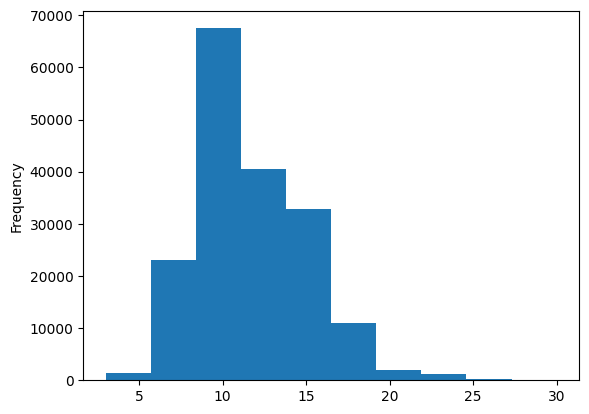

In [13]:
train_df.total_lines.plot.hist()

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
train_sentences[:10],len(train_sentences),len(val_sentences),len(test_sentences)

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
  'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
  'there was a

##Make Numeric Labels

In [15]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot , val_labels_one_hot , test_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [16]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
#get Classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##MODEL-0 (Naive-Bayes)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-21 08:22:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-21 08:22:26 (87.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results,plot_loss_curves,compare_historys

In [24]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Text-Vectorization and Embedding

In [25]:
import numpy as np
from tensorflow.keras import layers

In [26]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [27]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([6.4740e+03, 2.9819e+04, 3.6870e+04, 3.9381e+04, 2.4304e+04,
        1.8048e+04, 9.0460e+03, 6.4160e+03, 3.3100e+03, 2.3210e+03,
        1.4530e+03, 7.9400e+02, 5.9300e+02, 3.8200e+02, 2.6500e+02,
        1.5100e+02, 1.2200e+02, 8.1000e+01, 5.8000e+01, 4.0000e+01,
        1.8000e+01, 2.5000e+01, 8.0000e+00, 1.2000e+01, 6.0000e+00,
        7.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,   7.55555556,  14.11111111,  20.66666667,
         27.22222222,  33.77777778,  40.33333333,  46.88888889,
         53.44444444,  60.        ,  66.55555556,  73.11111111,
         79.66666667,  86.22222222,  92.77777778,  99.33333333,
        105.88888889, 112.44444444, 119.        , 125.55555556,
        132.11111111, 138.66666667, 145.22222222, 151.77777778,
  

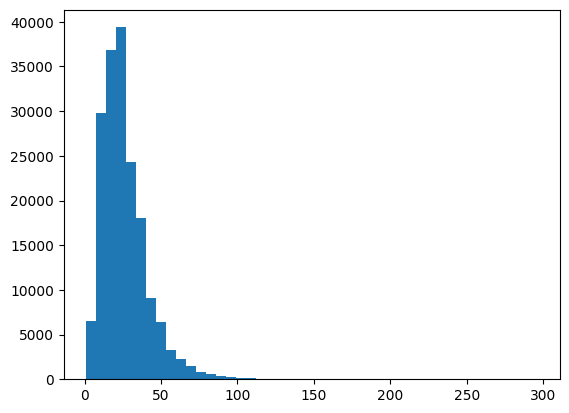

In [28]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=45)

In [29]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [30]:
max(sent_lens)
max_tokens=68000 ## From paper Table-2

In [31]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [32]:
text_vectorizer.adapt(train_sentences)

In [33]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"length of Text: {len(target_sentence)}")
print(f"Vectorized_Text:\n {text_vectorizer(target_sentence)}")

Text:
 after a @ year follow-up period involving @ patients who had their submandibular glands transferred for the prevention of xerostomia after radiotherapy for nasopharyngeal carcinoma , we found that clinical efficacy was good .
length of Text: 225
Vectorized_Text:
 [   21     8   157    94   173  1267    12    67    55   120 14407  7218
  5531    11     2   403     4  8534    21  1053    11  6372  1440    43
   208    28    47    79    10   745     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [34]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [36]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                       output_dim = 128,
                       mask_zero=True,
                       name="token_embedding")


In [37]:
print(f"Before Vectorization:{target_sentence}")
vectorized_sentence = text_vectorizer(target_sentence)
print(f"after Vectorization :\n {vectorized_sentence}")
embed_sentence = token_embed(vectorized_sentence)
print(f"after Embedding :\n {embed_sentence}")
print(f"Shape of embed sentence: {len(embed_sentence)}")

Before Vectorization:after a @ year follow-up period involving @ patients who had their submandibular glands transferred for the prevention of xerostomia after radiotherapy for nasopharyngeal carcinoma , we found that clinical efficacy was good .
after Vectorization :
 [   21     8   157    94   173  1267    12    67    55   120 14407  7218
  5531    11     2   403     4  8534    21  1053    11  6372  1440    43
   208    28    47    79    10   745     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
after Embedding :
 [[ 0.02425926  0.01999519  0.02440706 ...  0.01190733 -0.01517247
  -0.04215983]
 [ 0.00568416  0.04418049 -0.04797649 ...  0.01881174  0.02638653
   0.02804578]
 [-0.00573945  0.00092453 -0.0401775  ...  0.02251977 -0.03428044
  -0.00820794]
 ...
 [-0.03582206  0.04109992 -0.04948744 ... -0.02708081 -0.02646222
   0.00157434]
 [-0.03582206  0.04109992 -0.04948744 ... -0.0

In [38]:
#Using TF-DATA API
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_labels_one_hot.shape , train_labels_one_hot

((180040, 5),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

In [40]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [41]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_conv1d")

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [42]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [43]:
model_1_history=model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9174 - accuracy: 0.6363 - val_loss: 0.6867 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6547 - accuracy: 0.7583 - val_loss: 0.6281 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6150 - accuracy: 0.7766 - val_loss: 0.5964 - val_accuracy: 0.7829


In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5958 - accuracy: 0.7860


[0.5958164930343628, 0.7859790921211243]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.2833999e-01, 1.5030429e-01, 7.3464565e-02, 3.2415557e-01,
        2.3735618e-02],
       [4.4051638e-01, 2.7958858e-01, 1.4013732e-02, 2.5493461e-01,
        1.0946692e-02],
       [1.5930218e-01, 6.2221247e-03, 1.4259139e-03, 8.3300585e-01,
        4.4033048e-05],
       ...,
       [3.6782128e-06, 6.1428384e-04, 6.6290383e-04, 4.9803489e-06,
        9.9871421e-01],
       [4.6655640e-02, 4.4584754e-01, 9.9597879e-02, 5.8879327e-02,
        3.4901965e-01],
       [1.8911988e-01, 7.0544457e-01, 3.6242336e-02, 3.8364153e-02,
        3.0829115e-02]], dtype=float32)

In [46]:
model_1_pred = tf.argmax(model_1_pred_probs,axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [47]:
model_1_results=calculate_results(val_labels_encoded,model_1_pred)
model_1_results

{'accuracy': 78.5979081159804,
 'precision': 0.7826217394421506,
 'recall': 0.7859790811598041,
 'f1': 0.7832780087409795}

In [48]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#MODEL-2 (FEATURE-EXTRACTION)

In [49]:
import tensorflow_hub as hub

tf_hub = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                        trainable=False,
                        name="USE")

In [50]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
there is some evidence to suggest that one or two doses of the hpv vaccine provides similar protection to the three-dose regimen .

Sentence after embedding:
[ 0.02234448  0.03878799 -0.06461541 -0.03770111 -0.07034132  0.024043
  0.02644145 -0.01956193  0.0414215   0.06091356  0.08966491 -0.06403675
  0.05034352  0.02638619  0.00721967 -0.03100551 -0.0898828  -0.03908058
  0.00586319 -0.00552934  0.00170088  0.00825466 -0.07213596  0.05763002
  0.05560753  0.07001543 -0.01992217 -0.02104607  0.08191874 -0.0089253 ] (truncated output)...

Length of sentence embedding:
512


In [51]:
inputs = layers.Input(shape=[],dtype=tf.string)
x = tf_hub(inputs)
x = layers.Dense(128,activation="relu")(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs,name="model_2_USE")


model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [53]:
model_2_history = model_2.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9192 - accuracy: 0.6479 - val_loss: 0.8000 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7703 - accuracy: 0.7011 - val_loss: 0.7580 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7546 - accuracy: 0.7124 - val_loss: 0.7412 - val_accuracy: 0.7131


In [54]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7430 - accuracy: 0.7133


[0.7429887652397156, 0.7132927179336548]

In [55]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs


945/945 [==============================] - 10s 10ms/step


array([[0.43869165, 0.35109356, 0.00285744, 0.19839144, 0.00896594],
       [0.3543674 , 0.49629474, 0.00399937, 0.14168938, 0.00364915],
       [0.224039  , 0.18573804, 0.01569368, 0.5330691 , 0.04146013],
       ...,
       [0.00192076, 0.00507422, 0.04879864, 0.00108628, 0.94312006],
       [0.00459797, 0.0506751 , 0.19877687, 0.00145692, 0.7444932 ],
       [0.1752362 , 0.20232871, 0.5551821 , 0.00537849, 0.06187452]],
      dtype=float32)

In [56]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [57]:
model_2_results=calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.32927313650205,
 'precision': 0.7138731192547267,
 'recall': 0.7132927313650205,
 'f1': 0.7102622791130426}

##MODEL-3 (CONV1D-CHARCTER-EMBEDDING)

In [58]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [59]:
def split_chars(text):
  return " ".join(list(text))

In [60]:
split_chars(random_training_sentence)

't h e r e   i s   s o m e   e v i d e n c e   t o   s u g g e s t   t h a t   o n e   o r   t w o   d o s e s   o f   t h e   h p v   v a c c i n e   p r o v i d e s   s i m i l a r   p r o t e c t i o n   t o   t h e   t h r e e - d o s e   r e g i m e n   .'

In [61]:
train_chars = [split_chars(sentences) for sentences in train_sentences]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
char_lens = [len(sentences) for sentences in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

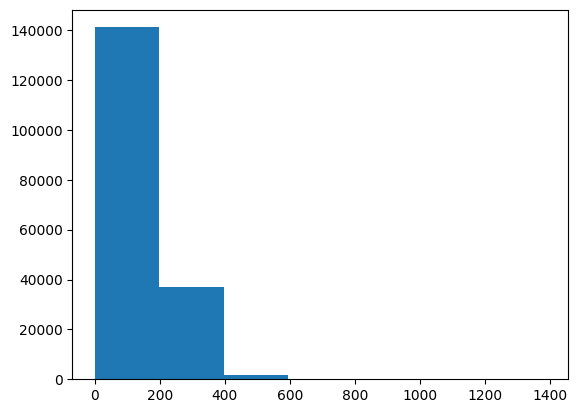

In [63]:
plt.hist(char_lens,bins=7)

In [64]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [65]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
n o   w o m e n   r e p o r t e d   a d v e r s e   e v e n t s   r e l a t e d   t o   s e x u a l   d y s f u n c t i o n   .

Length of chars: 55

Vectorized chars:
[[ 6  7 20  7 15  2  6  8  2 14  7  8  3  2 10  5 10 21  2  8  9  2  2 21
   2  6  3  9  8  2 12  5  3  2 10  3  7  9  2 24 16  5 12 10 19  9 17 16
   6 11  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [69]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [70]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
n o   w o m e n   r e p o r t e d   a d v e r s e   e v e n t s   r e l a t e d   t o   s e x u a l   d y s f u n c t i o n   .

Embedded chars (after vectorization and embedding):
[[[ 0.01287954  0.01777444  0.02502671 ...  0.02689439 -0.00629449
    0.00780978]
  [-0.04198031  0.04111845 -0.01126319 ...  0.01967004  0.00622432
    0.00098989]
  [ 0.01487393  0.04327102 -0.00044736 ... -0.03195987 -0.00907553
   -0.01158245]
  ...
  [ 0.03647672 -0.02974709  0.00117413 ... -0.01293577  0.01626667
    0.00882627]
  [ 0.03647672 -0.02974709  0.00117413 ... -0.01293577  0.01626667
    0.00882627]
  [ 0.03647672 -0.02974709  0.00117413 ... -0.01293577  0.01626667
    0.00882627]]]

Character embedding shape: (1, 290, 25)


In [71]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64,kernel_size=5,strides=1,padding="valid",activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_char")

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [72]:
model_3.summary()

Model: "model_3_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                

In [73]:
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset_char

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
model_3_history = model_3.fit(train_dataset_char,steps_per_epoch=int(0.1*len(train_dataset_char)),
                              epochs=3,
                              validation_data=val_dataset_char,
                              validation_steps=int(0.1*len(val_dataset_char)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 1.2658 - accuracy: 0.4855 - val_loss: 1.0575 - val_accuracy: 0.5841
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0269 - accuracy: 0.5849 - val_loss: 0.9692 - val_accuracy: 0.6193
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9525 - accuracy: 0.6208 - val_loss: 0.8928 - val_accuracy: 0.6499


In [75]:
model_3.evaluate(val_dataset_char)

945/945 [==============================] - 3s 3ms/step - loss: 0.9104 - accuracy: 0.6448


[0.910420835018158, 0.6447768807411194]

In [76]:
model_3_pred_probs = model_3.predict(val_dataset_char)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.17632683, 0.385675  , 0.08497303, 0.3240501 , 0.02897515],
       [0.07673981, 0.7370536 , 0.01269381, 0.0852275 , 0.08828531],
       [0.09440174, 0.1791876 , 0.42512485, 0.2779458 , 0.02334008],
       ...,
       [0.03090329, 0.08930289, 0.14561827, 0.06799652, 0.666179  ],
       [0.03413863, 0.11612435, 0.39443353, 0.04010538, 0.4151981 ],
       [0.2807805 , 0.48362154, 0.11811961, 0.09906182, 0.0184165 ]],
      dtype=float32)

In [77]:
model_3_pred = tf.argmax(model_3_pred_probs,axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1])>

In [78]:
model_3_results = calculate_results(val_labels_encoded,model_3_pred)
model_3_results

{'accuracy': 64.47769098371508,
 'precision': 0.6394055333390221,
 'recall': 0.6447769098371507,
 'f1': 0.6304336897422952}

##Model-4:(Model2+model3)

In [79]:
#token
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_inputs")
token_embeded =  tf_hub(token_inputs)
token_output = layers.Dense(128,activation="relu")(token_embeded)
token_model = tf.keras.Model(token_inputs,token_output,name="token_embedding")

#charcter
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vector = char_vectorizer(char_inputs)
char_embeded = char_embed(char_vector)
char_output = layers.Bidirectional(layers.LSTM(24))(char_embeded)
char_model = tf.keras.Model(char_inputs,char_output,name="char_biLSTM")

#Cocatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

#Adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                        outputs=output_layer,name="model_token_char_embedding")

In [80]:
model_4.summary()

Model: "model_token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['tok

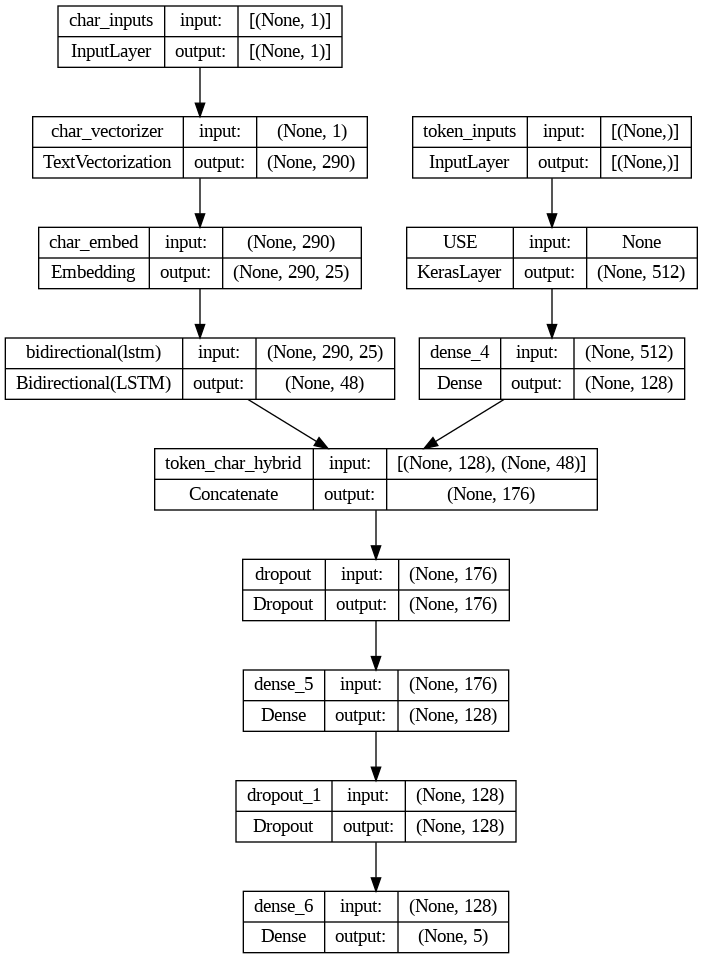

In [81]:
#Plotiing model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [82]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
##TF.DATA
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [85]:
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 49ms/step - loss: 0.9789 - accuracy: 0.6115 - val_loss: 0.7824 - val_accuracy: 0.7018
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.8049 - accuracy: 0.6906 - val_loss: 0.7159 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7784 - accuracy: 0.7026 - val_loss: 0.6918 - val_accuracy: 0.7377


In [86]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6937 - accuracy: 0.7354


[0.6937406063079834, 0.7353700399398804]

In [87]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 18ms/step


array([[4.64591891e-01, 3.68378788e-01, 5.24709793e-03, 1.53292775e-01,
        8.48942157e-03],
       [3.65241736e-01, 4.59410459e-01, 2.50458601e-03, 1.70749724e-01,
        2.09345738e-03],
       [3.30274403e-01, 1.12491824e-01, 6.58645406e-02, 4.62368876e-01,
        2.90003829e-02],
       ...,
       [4.73675958e-04, 8.42041243e-03, 5.05948216e-02, 2.40476584e-04,
        9.40270603e-01],
       [5.15116146e-03, 5.54981194e-02, 2.50754029e-01, 2.32579187e-03,
        6.86270952e-01],
       [1.71832800e-01, 3.82270962e-01, 3.20302814e-01, 2.98017859e-02,
        9.57916901e-02]], dtype=float32)

In [88]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [89]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.53700516351118,
 'precision': 0.7365694052323898,
 'recall': 0.7353700516351118,
 'f1': 0.7321505178216376}

In [90]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [91]:
model_1_results

{'accuracy': 78.5979081159804,
 'precision': 0.7826217394421506,
 'recall': 0.7859790811598041,
 'f1': 0.7832780087409795}

##Model-5 (Pretraine_token_embeding + char + token + Postional Level Embedding)

In [92]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [93]:
train_df["line_number"].value_counts

<bound method IndexOpsMixin.value_counts of 0          0
1          1
2          2
3          3
4          4
          ..
180035     7
180036     8
180037     9
180038    10
180039    11
Name: line_number, Length: 180040, dtype: int64>

<Axes: ylabel='Frequency'>

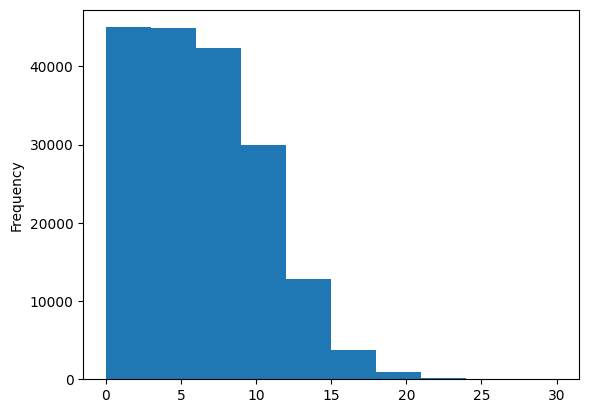

In [95]:
train_df.line_number.plot.hist()

In [98]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [99]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

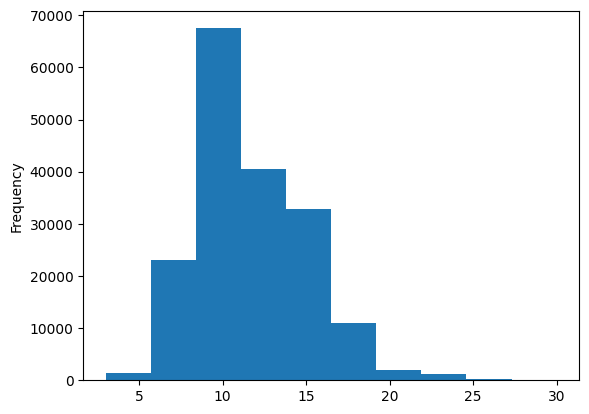

In [100]:
train_df.total_lines.plot.hist()

In [101]:
np.percentile(train_df.total_lines,98)

20.0

In [103]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [106]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [107]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_inputs[0][0]']  

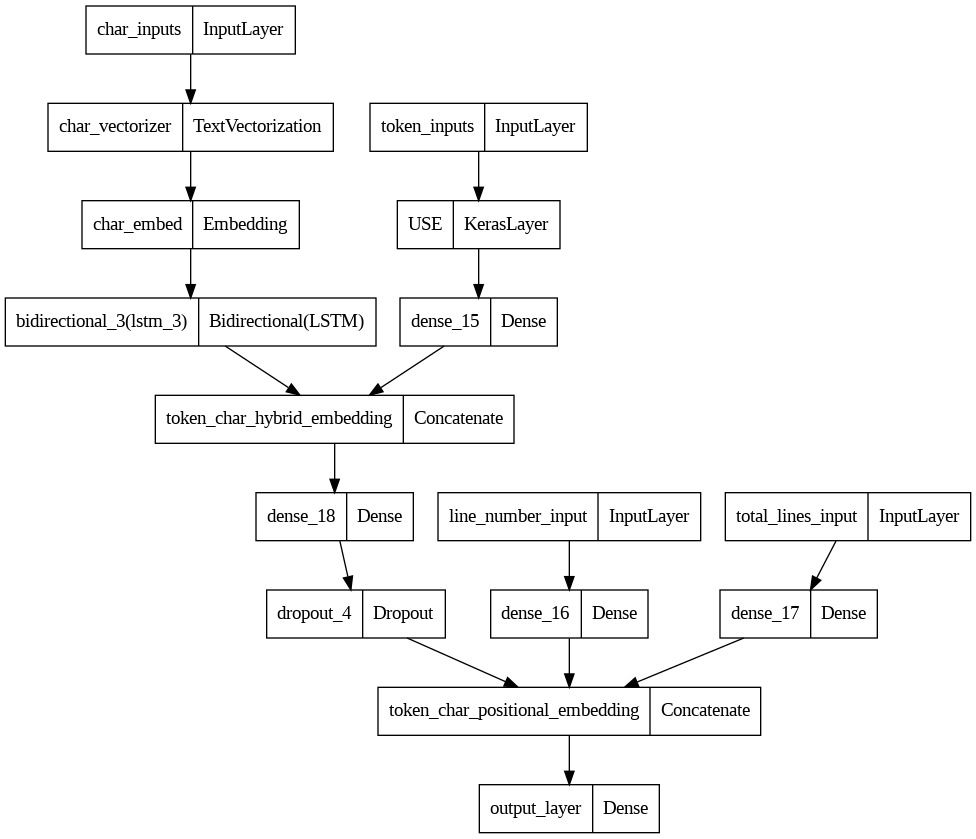

In [108]:
plot_model(model_5)

In [109]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7aa45026b280> True
<keras.src.engine.input_layer.InputLayer object at 0x7aa4e48f8490> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7aa45b4382e0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7aa4e0e6c280> False
<keras.src.layers.core.embedding.Embedding object at 0x7aa4e09ab9a0> True
<keras.src.layers.core.dense.Dense object at 0x7aa4e42e70a0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7aa4502dcbe0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7aa449e40d30> True
<keras.src.engine.input_layer.InputLayer object at 0x7aa4512c8f40> True
<keras.src.engine.input_layer.InputLayer object at 0x7aa4502df100> True
<keras.src.layers.core.dense.Dense object at 0x7aa449caba60> True
<keras.src.layers.core.dense.Dense object at 0x7aa45013d5d0> True
<keras.src.layers.core.dense.Dense object at 0x7aa449c14b50> True
<keras.src.layers.regularization.dropout.

In [110]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [111]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [113]:
model_5_history = model_5.fit(train_pos_char_token_dataset,steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1*len(val_pos_char_token_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9472 - accuracy: 0.8283 - val_loss: 0.9372 - val_accuracy: 0.8324
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9265 - accuracy: 0.8449 - val_loss: 0.9267 - val_accuracy: 0.8411
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9309 - accuracy: 0.8372 - val_loss: 0.9266 - val_accuracy: 0.8388


In [114]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.9246 - accuracy: 0.8412


[0.924556314945221, 0.841188907623291]

In [115]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.51010627, 0.09126199, 0.00934137, 0.37150213, 0.01778828],
       [0.5174157 , 0.10907301, 0.05063577, 0.3099314 , 0.01294413],
       [0.2575314 , 0.10807069, 0.12089662, 0.4526061 , 0.06089513],
       ...,
       [0.03501378, 0.08337948, 0.03006984, 0.02808645, 0.82345045],
       [0.03325105, 0.36760908, 0.08398581, 0.0283522 , 0.48680195],
       [0.1398805 , 0.7322857 , 0.06116954, 0.03160829, 0.03505593]],
      dtype=float32)

In [116]:
model_5_pred = tf.argmax(model_5_pred_probs,axis=1)
model_5_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [117]:
model_5_results = calculate_results(val_labels_encoded,model_5_pred)
model_5_results

{'accuracy': 84.11889315503774,
 'precision': 0.8404113789101524,
 'recall': 0.8411889315503773,
 'f1': 0.8403198504996063}

##Comparing all Models

In [120]:
import pandas as pd

all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.597908,0.782622,0.785979,0.783278
pretrained_token_embed,71.329273,0.713873,0.713293,0.710262
custom_char_embed_conv1d,64.477691,0.639406,0.644777,0.630434
hybrid_char_token_embed,73.537005,0.736569,0.735370,0.732151
tribrid_pos_char_token_embed,84.118893,0.840411,0.841189,0.840320


In [121]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [122]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.785979,0.782622,0.785979,0.783278
pretrained_token_embed,0.713293,0.713873,0.713293,0.710262
custom_char_embed_conv1d,0.644777,0.639406,0.644777,0.630434
hybrid_char_token_embed,0.735370,0.736569,0.735370,0.732151
tribrid_pos_char_token_embed,0.841189,0.840411,0.841189,0.840320


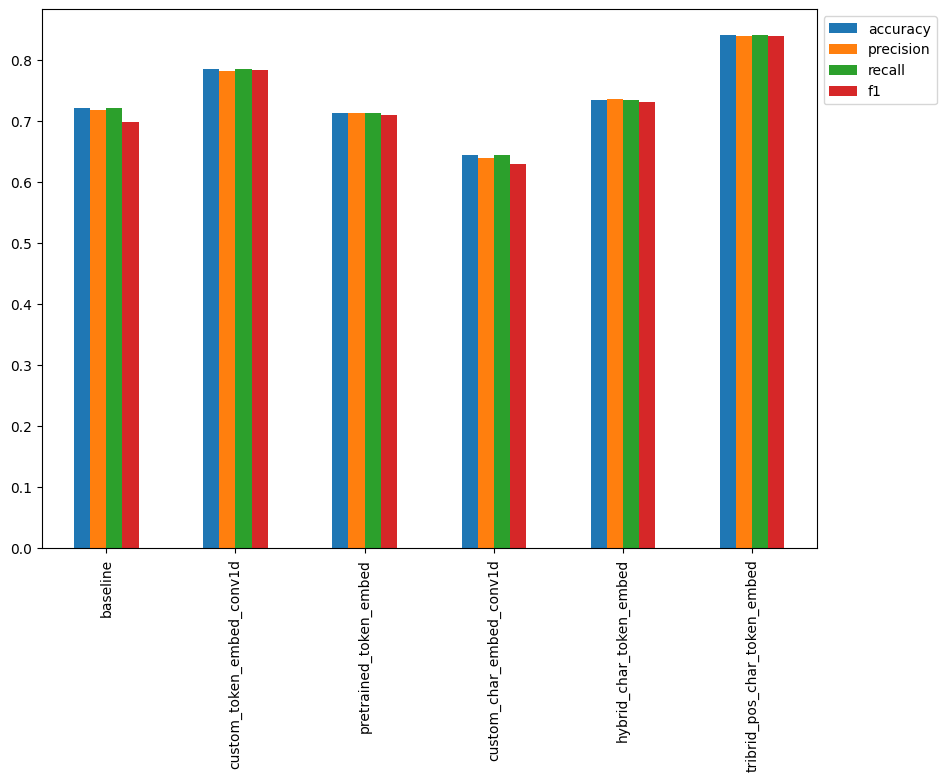

In [123]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

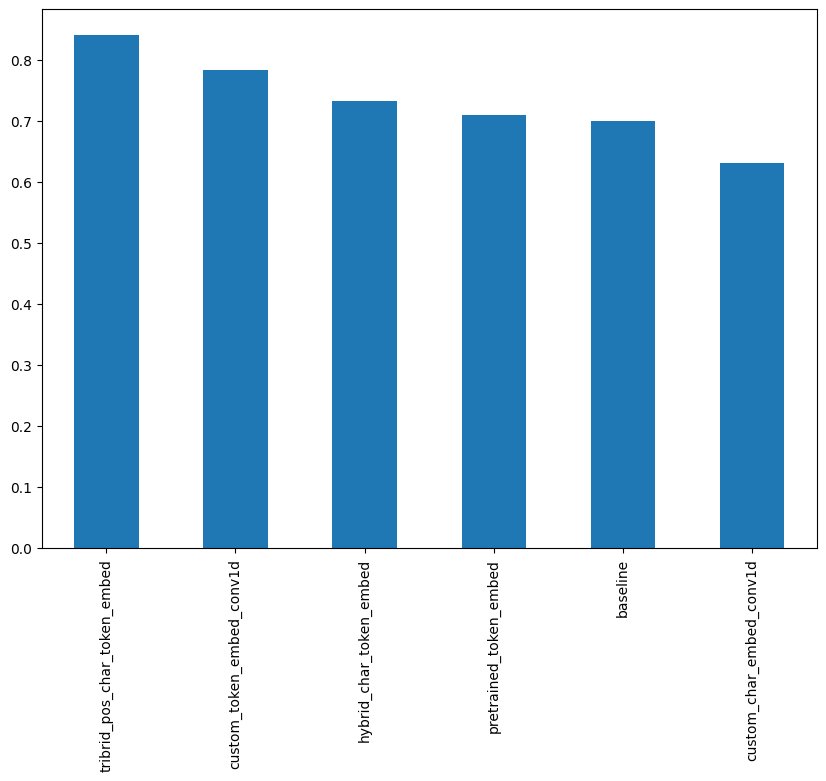

In [124]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

##Save and Load Model

In [125]:
model_5.save("skimlit_tribrid_model")

In [130]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_tribrid_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

In [131]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [133]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 84.11889315503774,
 'precision': 0.8404113789101524,
 'recall': 0.8411889315503773,
 'f1': 0.8403198504996063}

In [134]:
model_5_results

{'accuracy': 84.11889315503774,
 'precision': 0.8404113789101524,
 'recall': 0.8411889315503773,
 'f1': 0.8403198504996063}

In [135]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

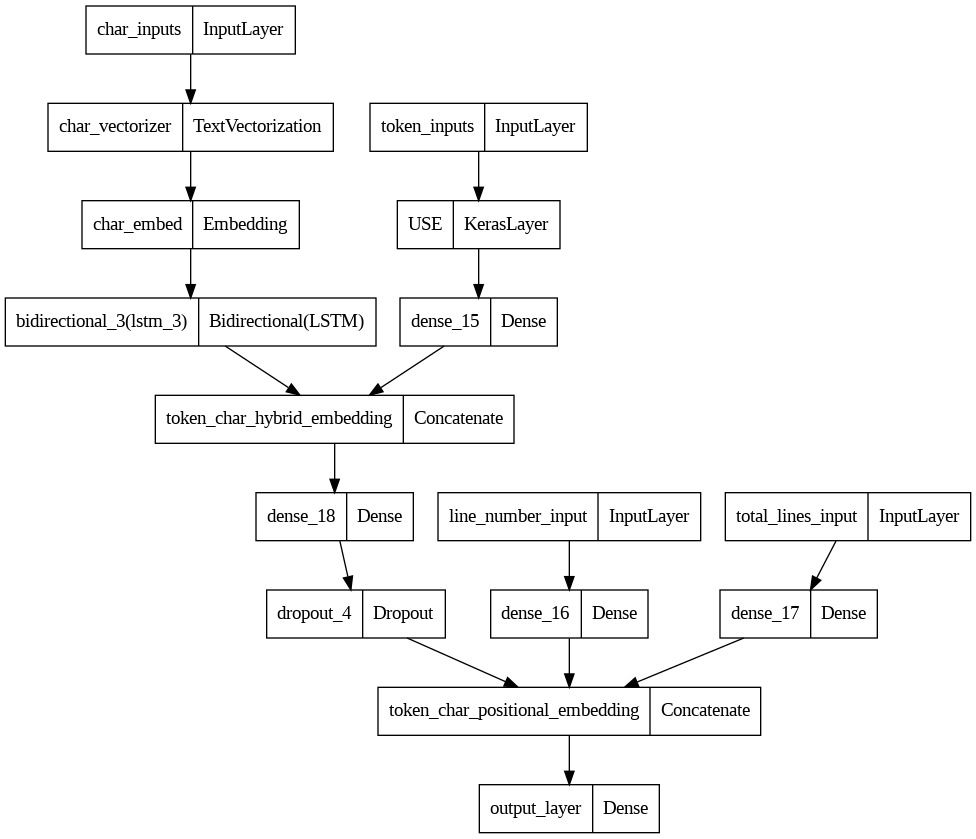

In [136]:
plot_model(loaded_model)

In [137]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [138]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [139]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 83.61041977766716,
 'precision': 0.8347771542818602,
 'recall': 0.8361041977766717,
 'f1': 0.8350889398069855}

In [140]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 14.6 s, sys: 720 ms, total: 15.4 s
Wall time: 14.7 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS

In [141]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.468363,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.355196,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.757324,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.644664,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.744003,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.872728,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.494830,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.578323,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.475721,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.580334,True


In [142]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.959068,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.936227,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.935947,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.933830,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.932960,False
...,...,...,...,...,...,...,...
3692,RESULTS,the primary end point was in-stent late loss a...,3,11,METHODS,0.838135,False
8358,CONCLUSIONS,nct@ .,11,11,BACKGROUND,0.836722,False
12459,RESULTS,adherence to follow-up was measured .,4,13,METHODS,0.836630,False
29007,RESULTS,control group patients received a wallet card ...,5,14,METHODS,0.835781,False


In [143]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9590675234794617, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9362266659736633, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.935947060585022, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9338304996490479, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9329603910446167, Line number: 15, Total lines: 15

Text:
-lsb- netherlands trial register ( http://www.trialregister.nl/trialreg/index.asp ) , nr @ , date of registration @ december @ . -rsb-

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9250435829162598, Line number: 4, Total lines: 6

Text:

In [144]:
import json
# Download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-06-21 09:44:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-06-21 09:44:48 (95.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [145]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [146]:
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer")
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [147]:
total_lines_in_sample = len(abstract_lines)

# Going through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [148]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [149]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [150]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [151]:
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 3.28 s, sys: 40.7 ms, total: 3.32 s
Wall time: 3.38 s


array([[0.28690514, 0.10211611, 0.0174861 , 0.5552143 , 0.03827835],
       [0.09694309, 0.03847259, 0.6550533 , 0.13190189, 0.0776291 ],
       [0.14318798, 0.06731336, 0.513035  , 0.15959392, 0.11686973],
       [0.10451848, 0.15988418, 0.537608  , 0.07666254, 0.12132671],
       [0.05492591, 0.09129702, 0.35582656, 0.05322538, 0.44472516],
       [0.03451477, 0.09731475, 0.53833646, 0.04602934, 0.28380468],
       [0.02481512, 0.12711091, 0.06801536, 0.02557305, 0.7544856 ],
       [0.01728837, 0.10049945, 0.13822778, 0.03018529, 0.71379906]],
      dtype=float32)

In [152]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [153]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [154]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
